# Learning Goals
In Assignment 2, we learned how to construct networks of spiking neurons and propagate information through a network of fixed weights. In this assignment, you will learn how to train network weights for a given task using brain-inspired learning rules.

Let's import all the libraries required for this assignment. 

In [1]:
import math
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt

# Question 1: Training a Network

## 1a. 
What is the purpose of a learning algorithm? In other words, what does a learning algorithm dictate, and what is the objective of it?





## Answer 1a. 
<font color='red'>
The purpose of a learning algorithm is to train a machine to discern between different stimuli, or inputs. This is done by having the algorithm exhibit different responses, or output, to different stimuli, then rewarding it for accurate answers, and either penalyzing it or witholding a reward for inaccurate answers. 
</font>


## 1b. 
Categorize and explain the various learning algorithms w.r.t. biological plausibility. Can you explain the tradeoffs involved with the different learning rules? *Hint: Think computational advantages and disadvantages of biological plausibility.*

A non biologically plausible way of learning is backpropogation, where output results essentially are iterated through the layers of the network to change connection weights. It's an efficient algorithm, but it is not aligned with the actual functions and mechanisms of the brain, making it less reliable for things like robotics. 

## Answer 1b.
<font color='red'>
A non biologically plausible way of learning is backpropogation, where output results essentially are iterated through the layers of the network to change connection weights. It's an efficient algorithm, but it is not aligned with the actual functions and mechanisms of the brain, making it less reliable for true models of the brain. A more biological learning algorithm is something like hebbian learning, where neurons that fire in synchrosity develop stronger connections. Within these learning networks, we can introduce different models (like the hodgkin huxley neuron) that represent biologically accurate membrane voltage dynamics. However, biologically accurate models like hebbian learning lack explicit mechanisms for error detection, meaning it's harder for the network to tell whether it's accurate or inaccurate.
</font>

# Question 2: Hebbian Learning

## 2a.

In this exercise, you will implement the hebbian learning rule to solve AND Gate. First, we need to create a helper function to generate the training data. The function should return lists of tuples where each tuple comprises of numpy arrays of rate-coded inputs and the corresponding rate-coded output. 

Below is the function to generate the training data. Fill the components to return the training data. 

In [2]:
def genANDTrainData(snn_timestep):
    """ 
    Function to generate the training data for AND 
        Args:
            snn_timestep (int): timesteps for SNN simulation
        Return:
            train_data (list): list of tuples where each tuple comprises of numpy arrays of rate-coded inputs and output
        
        Write the expressions for encoding 0 and 1. Then append all 4 cases of AND gate to the list train_data
    """
    
    #Initialize an empty list for train data
    train_data = []
    #encode 0. Numpy random choice function might be useful here. 
    encode0 = np.random.choice(a=[0,1], size=snn_timestep, p=[0.95, 0.05])
    
    #encode 1. Numpy random choice function might be useful here. 
    encode1 = np.random.choice(a=[0,1], size=snn_timestep, p=[0.05, 0.95])
    
    #Append all 4 cases of AND gate to train_data. Numpy stack operation might be useful here. 
    arr00 = np.stack((encode0, encode0))
    arr01 = np.stack((encode0, encode1))
    arr10 = np.stack((encode1, encode0))
    arr11 = np.stack((encode1, encode1))
    out0 = encode0
    out1 = encode1
    train_data.append((arr00, out0))
    train_data.append((arr01, out0))
    train_data.append((arr10, out0))
    train_data.append((arr11, out1))


    return train_data

## 2b. 
We will use the implementation of the network from assignment 2 to create an SNN comprising of one input layer and one output layer. Can you explain algorithmically, how you can use this simple architecture to learn AND gate. Your algorithm should comprise of encoding, forward propagation, network training, and decoding steps. 

## Answer 2b. 

<font color='red'>
The logical 0 in the and gate will be represented with a low firing rate, and the logical 1 will be represented by a high firing rate. Each input neuron corresponds to either logical 0 or 1. Over time, the network will be trained, and neurons representing logical 0s will not form strong connections with the output layer, while neurons representing logical ones will. This will create a correspondence of stronger connections to producing expected AND gate output.
</font>

The SNN has already been implemented for you. You do not need to do anything here. Just understand the implementation so that you can use it in the later parts. 

In [3]:
class LIFNeurons:
    """ 
        Define Leaky Integrate-and-Fire Neuron Layer 
        This class is complete. You do not need to do anything here.
    """

    def __init__(self, dimension, vdecay, vth):
        """
        Args:
            dimension (int): Number of LIF neurons in the layer
            vdecay (float): voltage decay of LIF neurons
            vth (float): voltage threshold of LIF neurons
        
        """
        self.dimension = dimension
        self.vdecay = vdecay
        self.vth = vth

        # Initialize LIF neuron states
        self.volt = np.zeros(self.dimension)
        self.spike = np.zeros(self.dimension)

    def reset_state(self):
        self.volt[:] = 0.0
        self.spike[:] = 0.0
    
    def __call__(self, psp_input):
        """
        Args:
            psp_input (ndarray): synaptic inputs 
        Return:
            self.spike: output spikes from the layer
                """
        self.volt = self.vdecay * self.volt * (1. - self.spike) + psp_input
        self.spike = (self.volt > self.vth).astype(float)
        return self.spike

class Connections:
    """ Define connections between spiking neuron layers """

    def __init__(self, weights, pre_dimension, post_dimension):
        """
        Args:
            weights (ndarray): connection weights
            pre_dimension (int): dimension for pre-synaptic neurons
            post_dimension (int): dimension for post-synaptic neurons
        """
        self.weights = weights
        self.pre_dimension = pre_dimension
        self.post_dimension = post_dimension
    
    def __call__(self, spike_input):
        """
        Args:
            spike_input (ndarray): spikes generated by the pre-synaptic neurons
        Return:
            psp: postsynaptic layer activations
        """
        psp = np.matmul(self.weights, spike_input)
        return psp
    
    
class SNN:
    """ Define a Spiking Neural Network with No Hidden Layer """

    def __init__(self, input_2_output_weight, 
                 input_dimension=2, output_dimension=2,
                 vdecay=0.5, vth=0.5, snn_timestep=20):
        """
        Args:
            input_2_hidden_weight (ndarray): weights for connection between input and hidden layer
            hidden_2_output_weight (ndarray): weights for connection between hidden and output layer
            input_dimension (int): input dimension
            hidden_dimension (int): hidden_dimension
            output_dimension (int): output_dimension
            vdecay (float): voltage decay of LIF neuron
            vth (float): voltage threshold of LIF neuron
            snn_timestep (int): number of timesteps for inference
        """
        self.snn_timestep = snn_timestep
        self.output_layer = LIFNeurons(output_dimension, vdecay, vth)
        self.input_2_output_connection = Connections(input_2_output_weight, input_dimension, output_dimension)

    def reset_state(self):
        self.output_layer.reset_state()
    
    def __call__(self, spike_encoding):
        """
        Args:
            spike_encoding (ndarray): spike encoding of input
        Return:
            spike outputs of the network
        """
        spike_output = np.zeros(self.output_layer.dimension)
        for tt in range(self.snn_timestep):
            input_2_output_psp = self.input_2_output_connection(spike_encoding[:, tt])
            output_spikes = self.output_layer(input_2_output_psp)
            spike_output += output_spikes
        return spike_output/self.snn_timestep      

## 2c. 
Next, you need to write a function for network training using hebbian learning rule. The function is defined below. You need to fill in the components so that the network weights are updated in the right manner. 

In [4]:
def hebbian(network, train_data, lr=1e-5, epochs=10):
    """ 
    Function to train a network using Hebbian learning rule
        Args:
            network (SNN): SNN network object
            train_data (list): training data 
            lr (float): learning rate
            epochs (int): number of epochs to train with. Each epoch is defined as one pass over all training samples. 
        
        Write the operations required to compute the weight increment according to the hebbian learning rule. Then increment the network weights. 
    """
    
    #iterate over the epochs
    for ee in range(epochs):
        #iterate over all samples in train_data
        for data in train_data:
            #compute the firing rate for the input
            inFireRate = np.mean(data[0], axis=1)
            #compute the firing rate for the output
            outFireRate = np.mean(data[1])
            #compute the correlation using the firing rates calculated above
            heb =  lr * (outFireRate * inFireRate)
            #compute the weight increment
            network.input_2_output_connection.weights += heb

## 2d. 
In this exercise, you will use your implementations above to train an SNN to learn AND gate. 

In [5]:
#Define a variable for input dimension
inputDim = 2
#Define a variable for output dimension
outputDim = 1
#Define a variable for voltage decay
vtd = 0.3
#Define a variable for voltage threshold
vth = 0.5
#Define a variable for snn timesteps
timesteps = 50
#Initialize randomly the weights from input to output. Numpy random rand function might be useful here. 
ioweight = np.random.rand(outputDim, inputDim) * 0.5
#print the initial weights
print(ioweight)

#Initialize an snn using the arguments defined above
network = SNN(ioweight, input_dimension=inputDim, output_dimension=outputDim, vdecay=vtd, 
              vth=vth, snn_timestep=timesteps)
#Get the training data for AND gate using the function defined in 2a. 
trainData = genANDTrainData(timesteps)
#Train the network using the function defined in 2c. with the appropriate arguments
hebbian(network, trainData, lr=1e-5,epochs=10)

#Test the trained network and print the network output for all 4 cases. 
for row in trainData:
    inp, out = row
    network.reset_state() 
    netout = network(inp)
    print("output:\n", netout)
    print("--------------------------")

print(network.input_2_output_connection.weights)



[[0.03815414 0.3899594 ]]
output:
 [0.]
--------------------------
output:
 [0.46]
--------------------------
output:
 [0.]
--------------------------
output:
 [0.46]
--------------------------
[[0.03825046 0.39005572]]


# Question 3: Limitations of Hebbian Learning rule

## 3a. 
Can you learn the AND gate using 2 neurons in the output layer instead of one? If yes, describe what changes you might need to make to your algorithm in 2b. If not, explain why not, and what consequences it might entail for the use of hebbian learning for complex real-world tasks. 

## Answer 3a.
<font color='red'>
You could theoretically have 2 neurons in the output layer by having one represent logical 0 and the other represent logical 1. In order to do this, there would need to be a spike train for both output neurons and the firing rate would have to be computed for each. We would also have to get the outer product of the input firing rates and output firing rates. 
</font>

## 3b. 
Train the network using hebbian learning for AND gate with the same arguments as defined in 2d. but now multiply the number of epochs by 20. Can your network still learn AND gate correctly? Inspect the initial and final network weights, and compare them against the network weights in 2d. Based on this, explain your observations for the network behavior. 

In [6]:
#Implementation for 3b. (same as 2d. but with change of one argument)
#Define a variable for input dimension
inputDim = 2
#Define a variable for output dimension
outputDim = 1
#Define a variable for voltage decay
vtd = 0.3
#Define a variable for voltage threshold
vth = 0.5
#Define a variable for snn timesteps
timesteps = 50
#Initialize randomly the weights from input to output. Numpy random rand function might be useful here. 
ioweight = np.random.rand(outputDim, inputDim) * 0.5
#print the initial weights
print(ioweight)

#Initialize an snn using the arguments defined above
network = SNN(ioweight, input_dimension=inputDim, output_dimension=outputDim, vdecay=vtd, 
              vth=vth, snn_timestep=timesteps)
#Get the training data for AND gate using the function defined in 2a. 
trainData = genANDTrainData(timesteps)
#Train the network using the function defined in 2c. with the appropriate arguments
hebbian(network, trainData, lr=1e-5,epochs=(10*20))

#Test the trained network and print the network output for all 4 cases. 
for row in trainData:
    inp, out = row
    network.reset_state() 
    netout = network(inp)
    print("output:\n", netout)
    print("--------------------------")

print(network.input_2_output_connection.weights)


[[0.40641478 0.21385242]]
output:
 [0.02]
--------------------------
output:
 [0.02]
--------------------------
output:
 [0.46]
--------------------------
output:
 [0.94]
--------------------------
[[0.40822118 0.21565882]]


## Answer 3b. 
<font color='red'>
The weights increase more drastically and consistently with the AND gate definitions over longer epochs. 
</font>

## 3c. 
Based on your observations and response in 3b., can you explain another limitation of hebbian learning rule w.r.t. weight growth? Can you also suggest a possible remedy for it?

## Answer 3c. 
<font color='red'>
When you increase epochs, the weight of all connections will increase. Therefore, if you had a really large number of epochs, neurons not meant to have strong connections will eventually attain strong connections. This can saturate the output, as inter neuronal weights will be incorrect.
</font>

## 3d. 
To resolve the issues with hebbian learning, one possibility is Oja's rule. In this exercise, you will implement and train an SNN using Oja's learning rule. 

In [7]:
def oja(network, train_data, lr=1e-5, epochs=10):
    """ 
    Function to train a network using Hebbian learning rule
        Args:
            network (SNN): SNN network object
            train_data (list): training data 
            lr (float): learning rate
            epochs (int): number of epochs to train with. Each epoch is defined as one pass over all training samples. 
        
        Write the operations required to compute the weight increment according to the hebbian learning rule. Then increment the network weights. 
    """
    
    #iterate over the epochs
    for ee in range(epochs):
        #iterate over all samples in train_data
        for data in train_data:
            #compute the firing rate for the input
            inFireRate = np.mean(data[0], axis=1)
            #compute the firing rate for the output
            outFireRate = np.mean(data[1])
            #compute the weight increment
            y = outFireRate                         
            w = network.input_2_output_connection.weights  
            heb = lr * y * inFireRate
            oja = lr * (y**2) * w   
            #increment the weight
            network.input_2_output_connection.weights += (heb-oja)


Now, test your implementation below. 

In [8]:
#Define a variable for input dimension
inputDim = 2
#Define a variable for output dimension
outputDim = 1
#Define a variable for voltage decay
vtd = 0.3
#Define a variable for voltage threshold
vth = 0.5
#Define a variable for snn timesteps
timesteps = 50
#Initialize randomly the weights from input to output. Numpy random rand function might be useful here. 
ioweight = np.random.rand(outputDim, inputDim) * 0.5

print(ioweight)

#Initialize an snn using the arguments defined above
network = SNN(ioweight, input_dimension=inputDim, output_dimension=outputDim, vdecay=vtd, 
              vth=vth, snn_timestep=timesteps)
#Get the training data for AND gate using the function defined in 2a. 
trainData = genANDTrainData(timesteps)

#Train the network using the function defined in 3d. with the appropriate arguments
oja(network, trainData, lr=1e-5, epochs=10)

#Test the trained network and print the network output for all 4 cases. 
for row in trainData:
    inp, out = row
    network.reset_state() 
    netout = network(inp)
    print("output:\n", netout)
    print("--------------------------")

#Print Final Network Weights
print(network.input_2_output_connection.weights)


[[0.30177978 0.14378997]]
output:
 [0.02]
--------------------------
output:
 [0.04]
--------------------------
output:
 [0.04]
--------------------------
output:
 [0.42]
--------------------------
[[0.30184478 0.14386852]]


# Question 4: Spike-time dependent plasticity (STDP)

## 4a. 
What is the limitation with hebbian learning that STDP aims to resolve?

## Answer 4a. 
<font color='red'>
In hebbian learning, the timing of spikes aren't considered, so it doesn't fully consider whether one neuron causes another one to fire. STDP resolves this by using precise spike timing, so connections are strengthened only when the pre neuron fires before the post neuron.</font>

## 4b. 
Describe the algorithm to train a network using STDP learning rule. You do not need to describe encoding here. Your algorithm should be such that its naturally translatable to a program. 

## Answer 4b. 
<font color='red'>
As the STDP network runs over time, we analyze neuron membrane potentials and record when they spike (when they reach the threshold). The weight is then updated based on the timing difference between spikes. If the presynaptic neuron fired before the postsynaptic neuron, we increase the weight, but if the presynaptic neuron fires after, we decrease the weight. We also remove old spikes as time goes on so we are only considering newer ones.
</font>

## 4c. 
In this exercise, you will implement the STDP learning algorithm to train a network. STDP has many different flavors. For this exercise, we will use the learning rule defined in: https://dl.acm.org/doi/pdf/10.1609/aaai.v33i01.330110021. Pay special attention to Equations 2 and 3. 

Below is the class definition for STDP learning algorithm. Your task is to fill in the components so that the weights are updated in the right manner. 

In [9]:
class STDP():
    """Train a network using STDP learning rule"""
    def __init__(self, network, A_plus, A_minus, tau_plus, tau_minus, lr, snn_timesteps=20, epochs=30, w_min=0, w_max=1):
        """
        Args:
            network (SNN): network which needs to be trained
            A_plus (float): STDP hyperparameter
            A_minus (float): STDP hyperparameter
            tau_plus (float): STDP hyperparameter
            tau_minus (float): STDP hyperparameter
            lr (float): learning rate
            snn_timesteps (int): SNN simulation timesteps
            epochs (int): number of epochs to train with. Each epoch is defined as one pass over all training samples.  
            w_min (float): lower bound for the weights
            w_max (float): upper bound for the weights
        """
        self.network = network
        self.A_plus = A_plus
        self.A_minus = A_minus
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus
        self.snn_timesteps = snn_timesteps
        self.lr = lr
        self.time = np.arange(0, self.snn_timesteps, 1)
        self.sliding_window = np.arange(-4, 4, 1) #defines a sliding window for STDP operation. 
        self.epochs = epochs
        self.w_min = w_min
        self.w_max = w_max
    
    def update_weights(self, t, i):
        """
        Function to update the network weights using STDP learning rule
        
        Args:
            t (int): time difference between postsynaptic spike and a presynaptic spike in a sliding window
            i(int): index of the presynaptic neuron
        
        Fill the details of STDP implementation
        """
        #compute delta_w for positive time difference
        if t>0:
            delta_w = self.A_plus * np.exp(-t / self.tau_plus)

        #compute delta_w for negative time difference
        else:
            delta_w = -self.A_minus * np.exp(t / self.tau_minus)

        for j in range(self.network.output_layer.dimension):
            #update the network weights if weight increment is negative
            oldWeight = self.network.input_2_output_connection.weights[j, i]
            if delta_w < 0:
                w_new = oldWeight + self.lr * delta_w * (self.w_max - oldWeight)
            #update the network weights if weight increment is positive                
            else:
                w_new = oldWeight + self.lr * delta_w * (oldWeight - self.w_min)
            w_new = np.clip(w_new, self.w_min, self.w_max)
            self.network.input_2_output_connection.weights[j, i] = w_new

            
            
    def train_step(self, train_data_sample):
        """
        Function to train the network for one training sample using the update function defined above. 
        
        Args:
            train_data_sample (list): a sample from the training data
            
        This function is complete. You do not need to do anything here. 
        """
        input = train_data_sample[0]
        output = train_data_sample[1]
        for t in self.time:
            if output[t] == 1:
                for i in range(2):
                    for t1 in self.sliding_window:
                        if (0<= t + t1 < self.snn_timesteps) and (t1!=0) and (input[i][t+t1] == 1):
                            self.update_weights(t1, i)
    
    def train(self, training_data):
        """
        Function to train the network
        
        Args:
            training_data (list): training data
        
        This function is complete. You do not need to do anything here. 
        """
        for ee in range(self.epochs):
            for train_data_sample in training_data:
                self.train_step(train_data_sample)

Let's test the implementation

In [10]:
#Define a variable for input dimension
inputDim = 2
#Define a variable for output dimension
outputDim = 1
#Define a variable for voltage decay
vtd = 0.3
#Define a variable for voltage threshold
vth = 0.5
#Define a variable for snn timesteps
timesteps = 50
#Initialize randomly the weights from input to output. Numpy random rand function might be useful here. 
ioweight = np.random.rand(outputDim, inputDim) * 0.5

#Initialize an snn using the arguments defined above
network = SNN(ioweight, input_dimension=inputDim, output_dimension=outputDim, vdecay=vtd, 
              vth=vth, snn_timestep=timesteps)
#Get the training data for AND gate using the function defined in 2a. 
trainData = genANDTrainData(timesteps)

#Create an object of STDP class with appropriate arguments
stdp = STDP(network,A_plus=0.001,A_minus=0.001,tau_plus=5,tau_minus=5,lr=0.001,
            snn_timesteps=timesteps,epochs=30,w_min=0,w_max=1)
#Train the network using STDP
stdp.train(trainData)
#Test the trained network and print the network output for all 4 cases. 
for row in trainData:
    inp, out = row
    network.reset_state() 
    netout = network(inp)
    print("output:\n", netout)
    print("--------------------------")

#Print Final Network Weights
print(network.input_2_output_connection.weights)




output:
 [0.02]
--------------------------
output:
 [0.48]
--------------------------
output:
 [0.02]
--------------------------
output:
 [0.98]
--------------------------
[[0.26775141 0.44521656]]


# Question 5: OR Gate
Can you train the network with the same architecture in Q2-4 for learning the OR gate. You will need to create another function called genORTrainData. Then create an SNN and train it using STDP. 

In [11]:
#Write your implementation of genORTrainData here. 
def genORTrainData(snn_timestep):
    """ 
    Function to generate the training data for AND 
        Args:
            snn_timestep (int): timesteps for SNN simulation
        Return:
            train_data (list): list of tuples where each tuple comprises of numpy arrays of rate-coded inputs and output
        
        Write the expressions for encoding 0 and 1. Then append all 4 cases of AND gate to the list train_data
    """
    
    #Initialize an empty list for train data
    train_data = []
    #encode 0. Numpy random choice function might be useful here. 
    encode0 = np.random.choice(a=[0,1], size=snn_timestep, p=[0.99, 0.01])
    
    #encode 1. Numpy random choice function might be useful here. 
    encode1 = np.random.choice(a=[0,1], size=snn_timestep, p=[0.01, 0.99])
    
    #Append all 4 cases of AND gate to train_data. Numpy stack operation might be useful here. 
    arr00 = np.stack((encode0, encode0))
    arr01 = np.stack((encode0, encode1))
    arr10 = np.stack((encode1, encode0))
    arr11 = np.stack((encode1, encode1))
    out00 = encode0 
    out01 = encode1  
    out10 = encode1  
    out11 = encode1  

    train_data.append((arr00, out00))
    train_data.append((arr01, out01))
    train_data.append((arr10, out10))
    train_data.append((arr11, out11))


    return train_data

In [16]:
#Train the network for OR gate here using the implementation from 4c. 
#Define a variable for input dimension
inputDim = 2
#Define a variable for output dimension
outputDim = 1
#Define a variable for voltage decay
vtd = 0.3
#Define a variable for voltage threshold
vth = 0.5
#Define a variable for snn timesteps
timesteps = 50
#Initialize randomly the weights from input to output. Numpy random rand function might be useful here. 
ioweight = np.random.rand(outputDim, inputDim) * 0.5

#Initialize an snn using the arguments defined above
network = SNN(ioweight, input_dimension=inputDim, output_dimension=outputDim, vdecay=vtd, 
              vth=vth, snn_timestep=timesteps)
#Get the training data for AND gate using the function defined in 2a. 
trainData = genORTrainData(timesteps)

#Create an object of STDP class with appropriate arguments
stdp = STDP(network,A_plus=0.001,A_minus=0.001,tau_plus=5,tau_minus=5,lr=0.001,
            snn_timesteps=timesteps,epochs=40,w_min=0,w_max=1)
#Train the network using STDP
stdp.train(trainData)
#Test the trained network and print the network output for all 4 cases. 
for row in trainData:
    inp, out = row
    network.reset_state() 
    netout = network(inp)
    print("output:\n", netout)
    print("--------------------------")

#Print Final Network Weights
print(network.input_2_output_connection.weights)


output:
 [0.]
--------------------------
output:
 [0.5]
--------------------------
output:
 [0.5]
--------------------------
output:
 [1.]
--------------------------
[[0.49582574 0.41605784]]


# Question 6: XOR Gate
In this question, we will construct and train a multi-layer SNN with a single hidden layer to solve the XOR problem.

## 6a. 
Explain why a hidden layer is required for the XOR problem?

## Answer 6a.
<font color='red'>
No single neuron with only weighted inputs can divide the input space correctly. The boundaries of a XOR gate are nonlinear, so a two layer network can't represent the structure a XOR gate requires. So, we should add a hidden layer to allow nonlinear combinations. </font>

## 6b. 
You will need to create another function called genXORTrainData

In [21]:
#Write your implementation of genXORTrainData here. 
def genXORTrainData(snn_timestep):
    """ 
    Function to generate the training data for AND 
        Args:
            snn_timestep (int): timesteps for SNN simulation
        Return:
            train_data (list): list of tuples where each tuple comprises of numpy arrays of rate-coded inputs and output
        
        Write the expressions for encoding 0 and 1. Then append all 4 cases of AND gate to the list train_data
    """
    
    #Initialize an empty list for train data
    train_data = []
    #encode 0. Numpy random choice function might be useful here. 
    encode0 = np.random.choice(a=[0,1], size=snn_timestep, p=[0.99, 0.01])
    
    #encode 1. Numpy random choice function might be useful here. 
    encode1 = np.random.choice(a=[0,1], size=snn_timestep, p=[0.01, 0.99])
    
    #Append all 4 cases of AND gate to train_data. Numpy stack operation might be useful here. 
    arr00 = np.stack((encode0, encode0))
    arr01 = np.stack((encode0, encode1))
    arr10 = np.stack((encode1, encode0))
    arr11 = np.stack((encode1, encode1))
    out00 = encode0 
    out01 = encode1  
    out10 = encode1  
    out11 = encode0  

    train_data.append((arr00, out00))
    train_data.append((arr01, out01))
    train_data.append((arr10, out10))
    train_data.append((arr11, out11))


    return train_data


## 6c. 
You will need to create a 2-layer SNN using the LIFNeurons and Connections classes defined above. In addition to neurons defined at each layer, assume each non-output layer also contains a **tonic bias neuron** (neuron with **sustained** activity) that represents the background activity observed in each layer of a brain region defined by the SNN. A schematic for this is attached below:

![SNN_with_bias.png](SNN_with_bias.png)

In [18]:
class SNN2Layer:
    """
    Two-layer SNN using provided LIFNeurons and Connections.
    Forward returns mean output spikes (rate) over the trial.
    """

    def __init__(self, W_in_h, W_h_out,
                 input_dimension=2, hidden_dimension=24, output_dimension=1,
                 vdecay=0.5, vth=0.8, snn_timestep=50,
                 hidden_bias=0.08, output_bias=0.05):
        """
        Args:
            W_in_h   (ndarray): shape (hidden_dimension, input_dimension), init weights
            W_h_out  (ndarray): shape (output_dimension, hidden_dimension), init weights
            vdecay   (float): membrane decay for LIF layers
            vth      (float): spike threshold for LIF layers
            snn_timestep (int): steps per trial
            hidden_bias (float): small tonic bias added to hidden PSP each step
            output_bias (float): small tonic bias added to output PSP each step
        """
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension
        self.snn_timestep = snn_timestep

        self.hidden_layer = LIFNeurons(hidden_dimension, vdecay, vth)
        self.output_layer = LIFNeurons(output_dimension, vdecay, vth)

        self.in_to_hidden = Connections(W_in_h, input_dimension, hidden_dimension)
        self.hidden_to_out = Connections(W_h_out, hidden_dimension, output_dimension)

        self.W_in_h = self.in_to_hidden.weights
        self.W_h_out = self.hidden_to_out.weights
        self.hidden_bias = hidden_bias
        self.output_bias = output_bias
        
        ...

    def reset_state(self):
        self.hidden_layer.reset_state()
        self.output_layer.reset_state()

    def forward_rates(self, spike_encoding):
        """
        Run one trial and return:
            h_rate: mean hidden spikes per time step, shape (H,)
            o_rate: mean output spikes per time step, shape (1,)
        """
        hidden_spike_sum = np.zeros(self.hidden_layer.dimension)
        output_spike_sum = np.zeros(self.output_layer.dimension)

        self.reset_state()

        for t in range(self.snn_timestep):

            hidden_psp = self.in_to_hidden(spike_encoding[:, t])

            hidden_psp += self.hidden_bias

            h_spikes = self.hidden_layer(hidden_psp)
            hidden_spike_sum += h_spikes

            output_psp = self.hidden_to_out(h_spikes)

            output_psp += self.output_bias

            o_spikes = self.output_layer(output_psp)
            output_spike_sum += o_spikes

        h_rate = hidden_spike_sum / self.snn_timestep
        o_rate = output_spike_sum / self.snn_timestep

        return h_rate, o_rate
        ...

    def __call__(self, spike_encoding):
        """Return mean output spikes (rate) over the trial, shape (1,)."""
        _, o_rate = self.forward_rates(spike_encoding)
        return o_rate
        ...


## 6d. 
To train a network to solve the XOR problem, we will need to modify the Hebbian Learning Rule to use a biologically-motivated **3-factor modified Hebbian rule** that extends the rule with **supervision**. 

Core idea behind 3-factor rule:
* Let o_rate be the output neuron’s mean firing rate on a sample.
* Let h_rate be the hidden layer’s mean firing rates vector.
* Let in_rate be the input rates vector.
* Let y ∈ {0,1} be the target label for that sample (decoded from the label spikes).
* Let e = y - o_rate, represent the scalar error
  
**Update with centered activities to remove baseline bias**:
*    Keep exponential moving averages (EMAs) of hidden and input rates, h̄ and ī.
*    Center: h_c = h_rate - h̄, in_c = in_rate - ī.
**Weight updates (per sample)**:
*    Output weights: ΔW_h_out = η_out * e * h_c (Hebb with error gate)
*    Hidden weights: ΔW_in_h = η_in * e * (h_c ⊗ in_c) (outer product)
**Add tiny Oja-like decay terms to prevent runaway growth**:
*    W_h_out ← W_h_out − λ_out * (o_rate²) * W_h_out
*    W_in_h ← W_in_h − λ_in * (h_rate²) ⊙ W_in_h (row-wise)
**Clip weights to [w_min, w_max] after each sample**

This is “Hebb + (global) error” (a 3-factor rule) with centering and mild normalization.

**Note**: To avoid overfitting a single draw of Poisson spikes and to make the network learn rate mappings, regenerate the four XOR patterns every epoch.

In [19]:
class ModifiedHebbXOR:
    """
    3-factor modified Hebbian learning for XOR:
        - e = y - o_rate
        - ΔW_h_out = η_out * e * h_c - λ_out * (o_rate^2) * W_h_out
        - ΔW_in_h  = η_in  * e * (h_c ⊗ in_c) - λ_in * (h_rate^2) ⊙ W_in_h
    with EMA-centered rates (h̄, ī) and weight clipping to [w_min, w_max].
    """

    def __init__(self, network: SNN2Layer,
                 lr_in=0.02, lr_out=0.05, epochs=600,
                 w_min=-2.0, w_max=2.0,
                 l2_in=1e-4, l2_out=1e-4,
                 ema=0.97, snn_timesteps=50):
        self.net = network
        self.lr_in = lr_in
        self.lr_out = lr_out
        self.epochs = epochs
        self.w_min = w_min
        self.w_max = w_max
        self.l2_in = l2_in
        self.l2_out = l2_out
        self.ema = ema
        self.snn_timesteps = snn_timesteps

        # initialize EMAs for input and hidden layer
        self.h_bar = np.zeros(self.net.hidden_layer.dimension)
        self.in_bar = np.zeros(self.net.in_to_hidden.pre_dimension)

    def _epoch_data(self):
        """Generate fresh Poisson spike trains for XOR patterns."""
        X = np.array([[0,0],[0,1],[1,0],[1,1]])
        Y = np.array([0,1,1,0])
        spike_inputs = []

        for x in X:
            inp = np.zeros((2, self.snn_timesteps))
            for i in range(2):
                # encode 0 with low spike probability, 1 with higher
                p = 0.1 if x[i] == 0 else 0.6
                inp[i] = (np.random.rand(self.snn_timesteps) < p).astype(float)
            spike_inputs.append(inp)

        return spike_inputs, Y

    def train(self):
        """Train the network over multiple epochs with 3-factor Hebbian updates."""
        for ep in range(self.epochs):
            spike_inputs, targets = self._epoch_data()

            for inp, y in zip(spike_inputs, targets):
                h_rate, o_rate = self.net.forward_rates(inp)  
                o = o_rate[0]

                e = y - o

                self.h_bar = self.ema * self.h_bar + (1 - self.ema) * h_rate
                self.in_bar = self.ema * self.in_bar + (1 - self.ema) * inp.mean(axis=1)

                h_c = h_rate - self.h_bar
                in_c = inp.mean(axis=1) - self.in_bar

                dW_h_out = self.lr_out * e * h_c.reshape(1, -1)
                dW_h_out -= self.l2_out * (o_rate**2) * self.net.hidden_to_out.weights
                self.net.hidden_to_out.weights += dW_h_out

                outer = np.outer(h_c, in_c)  
                dW_in_h = self.lr_in * e * outer
                dW_in_h -= self.l2_in * (h_rate**2).reshape(-1,1) * self.net.in_to_hidden.weights
                self.net.in_to_hidden.weights += dW_in_h

                self.net.hidden_to_out.weights = np.clip(self.net.hidden_to_out.weights, self.w_min, self.w_max)
                self.net.in_to_hidden.weights  = np.clip(self.net.in_to_hidden.weights,  self.w_min, self.w_max)
        ...


## 6e 
Now test your implementation below

In [22]:
# Define hyperparameters below        
in_dim = 2
hid_dim = 24
out_dim = 1
timesteps = 50
# Randomly initalize the model weights
W_in_h  = np.random.uniform(-0.8, 0.8, size=(hid_dim, in_dim)) #You must define hid_dim, in_dim, and out_dim
W_h_out = np.random.uniform(-0.8, 0.8, size=(out_dim, hid_dim))

# Define 2-layer SNN for XOR problem
snn_xor = SNN2Layer(
    W_in_h=W_in_h,W_h_out=W_h_out,input_dimension=in_dim,hidden_dimension=hid_dim,
    output_dimension=out_dim,vdecay=0.5,vth=0.8,snn_timestep=timesteps,
    hidden_bias=0.08,output_bias=0.05
)

#Train the SNN with ModifiedHebbXOR
mhebbxor = ModifiedHebbXOR(
    network=snn_xor,lr_in=0.02,lr_out=0.05,epochs=600,
    w_min=-2.0,w_max=2.0,l2_in=1e-4,l2_out=1e-4,
    snn_timesteps=timesteps
)
mhebbxor.train()
# Evaluate results on one fresh draw of the four truth-table rows using genXORTrainData (print both the input data and the predicted values)
trainData = genXORTrainData(timesteps)

for inp, target in trainData:
    snn_xor.reset_state()
    o_rate = snn_xor(inp)
    
    print("output:", o_rate)
    print("--------------------------")


print("\nFinal W_in_h (excerpt):\n", snn_xor.in_to_hidden.weights[:3])
print("Final W_h_out (excerpt):\n", snn_xor.hidden_to_out.weights[:, :6])


output: [0.]
--------------------------
output: [1.]
--------------------------
output: [1.]
--------------------------
output: [0.]
--------------------------

Final W_in_h (excerpt):
 [[-0.69240949  0.47726874]
 [ 0.04697067 -0.24142447]
 [-0.10591928  0.01412993]]
Final W_h_out (excerpt):
 [[ 0.37349048  0.76085007  0.3659426   0.5129329   0.06322152 -0.09271967]]


## Question 7 — Geometric PCA (closed form)

In this question we switch from *spikes over time* to a more geometric view of the
same data. Each trial of the AND gate produces a 2-D **rate vector** $\mathbf{x}\in\mathbb{R}^2$ (one rate for each input channel). On this small
dataset we can:

1. Visualize the **geometry** of the four AND patterns as clusters in 2-D.
2. Use **Principal Component Analysis (PCA)** to find the directions of maximum
   variance.
3. Show how a simple **Hebbian learning rule with normalization** (Oja’s rule)
   performs online PCA.
4. Use the learned principal components as **features** for a simple AND
   classifier.
5. Extend to two PCs using **Sanger’s / GHA rule**, and relate reconstruction
   error to the **eigenvalues** of the covariance matrix.

## Q7a. Dataset: many AND samples as **rate vectors**
We convert each spike sample (2×T) to a rate vector $x\in\mathbb{R}^2$ by averaging across time, and derive the class label (AND of the two bits).

In earlier questions you generated spike trains for a 2-input AND gate:

- Each trial gives a spike matrix of shape \($2 \times T$\):  
  one row for input A, one row for input B, across \(T\) time steps.
- We convert this to a **rate vector** by averaging over time:
  
  $\mathbf{x} = \frac{1}{T} \sum_{t=1}^{T} \mathbf{s}(t) \in \mathbb{R}^2$,
  
  so \(\mathbf{x} = (r_A, r_B)\) is the firing rate of each input neuron.
- The **label** for that trial is the logical AND of the underlying bits
  (0 or 1).

Geometric picture:

- The four AND patterns \((0,0), (1,0), (0,1), (1,1)\) become four **clusters**
  in the 2-D rate plane.
- Noise in the spike encoding spreads each pattern into a little **blob**.
- PCA on these rate vectors will discover the main directions along which these
  blobs vary the most (e.g., roughly along the \([1,1]\) diagonal).

In [23]:
rng = np.random.default_rng(0)

def sample_AND_dataset(N=2000, T=20):
    X_rates, y = [], []
    for _ in range(N):
        cases = genANDTrainData(T)
        idx   = rng.integers(0, 4)
        x_spk, y_spk = cases[idx]
        x_rate = x_spk.mean(axis=1)
        bits = [(0,0),(1,0),(0,1),(1,1)][idx]
        y_lbl = int(bits[0] & bits[1])
        X_rates.append(x_rate)
        y.append(y_lbl)
    X = np.vstack(X_rates).astype(float)
    y = np.asarray(y, int)
    return X, y

T = 20
X, y = sample_AND_dataset(N=4000, T=T)
mu = X.mean(axis=0)
Xc = X - mu
print("X shape:", X.shape, "  mean:", mu)


X shape: (4000, 2)   mean: [0.50655   0.5040375]


λ: [0.20899313 0.20095329]


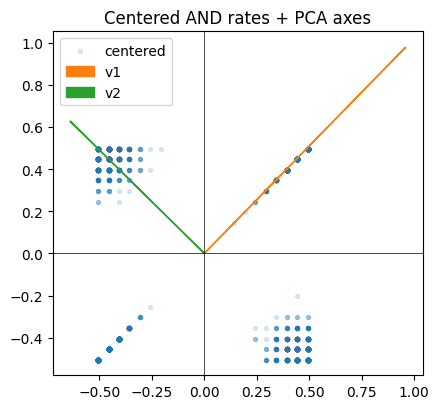

In [24]:
# Compute empirical covariance matrix of the centered data.
# Note: using N (Xc.shape[0]) in the denominator gives the population covariance estimate.

# eigvals/eigvecs from np.linalg.eigh are returned in ascending order for symmetric matrices.
# ascending order
N = Xc.shape[0]
covX = (Xc.T @ Xc) / N
lam, v = np.linalg.eigh(covX)
# Reverse to get descending order: lam[0] is the largest eigenvalue.
lam = lam[::-1]
v = v[:, ::-1]

v1 = v[:, 0]
v2 = v[:, 1]
# Comments for students:
# - lam contains the variances along each principal direction (eigenvalues).
# - v1 is the direction of maximum variance (first principal component).
# - Scaling arrows by sqrt(lam) gives a visual sense of standard deviation along each PC.
print("λ:", lam)

plt.figure(figsize=(4.5,4.2))
plt.scatter(Xc[:,0], Xc[:,1], s=8, alpha=0.15, label='centered')
scale = 3*np.sqrt(lam[0])
plt.arrow(0,0, *(scale*v1), color='C1', width=0.002, length_includes_head=True, label='v1')
plt.arrow(0,0, *(2*np.sqrt(lam[1])*v2), color='C2', width=0.002, length_includes_head=True, label='v2')
plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)
plt.legend(); plt.title('Centered AND rates + PCA axes'); plt.tight_layout(); plt.show()


## Q 7b. — **Oja’s rule** (online PCA, single unit)

PCA in closed form comes from the eigenvectors of the covariance matrix
\($\mathbf{C}$\) of the data. The **first principal component (PC)** is the unit
vector \($\mathbf{w}_1$\) that maximizes the variance of the projection
\($\mathbf{w}_1^\top \mathbf{x}$\).

Oja’s rule gives us an **online**, neuron-like way to learn this direction:

- Neuron output: \($y = \mathbf{w}^\top \mathbf{x}$\).
- Weight update:
  \[
  $\Delta \mathbf{w} = \eta\, y \bigl(\mathbf{x} - y\,\mathbf{w}\bigr)$,
  \]
  with small learning rate \($\eta$\).


Final w: [-0.75581486  0.65478539]


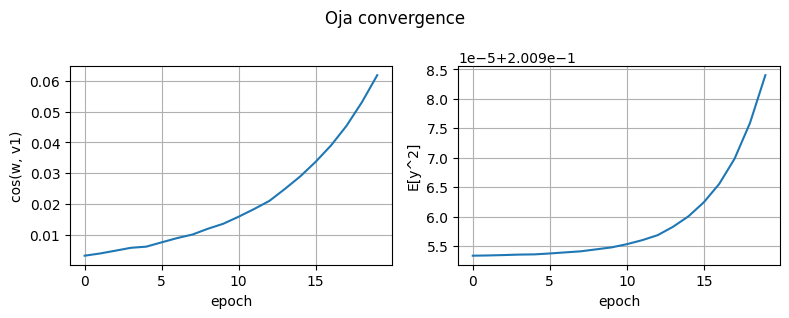

In [27]:
def oja_fit(Xc, lr=5e-3, epochs=10, w0=None, normalize_each_epoch=True, rng=rng):
    """
    Online PCA with Oja's rule (single principal component).

    Args:
        Xc : (N, D) data matrix, already mean-centered (zero-mean per feature)
        lr : learning rate η for Oja's rule
        epochs : number of passes over the dataset
        w0 : optional initial weight vector (D,). If None, random init.
        normalize_each_epoch : if True, L2-normalize w at the end of each epoch
        rng : NumPy random generator (for init and shuffling)

    Returns:
        w         : learned principal component (D,)
        cos_hist  : cosine similarity between w and true top eigenvector per epoch
        var_hist  : variance explained along w per epoch (mean squared projection)
    """

    # Dimensionality of each sample
    N, D = Xc.shape

    # Initialize weight vector w (our 1D "neuron") – random or from w0
    if w0 is None:
        w = rng.normal(size=D)
    else:
        w = w0.copy()
    w /= np.linalg.norm(w)

    # Normalize initial w to unit length (helps stability & comparability)
    cos_hist = []
    var_hist = []
    # For tracking learning progress
    # cosine similarity to true top PC
    # variance captured along w
    # Compute the true top eigenvector v1 for comparison (offline PCA)
    # Covariance (up to a constant factor) is (X^T X)/N
    covX = (Xc.T @ Xc) / N
    lam, v = np.linalg.eigh(covX)
    v1 = v[:, -1]

    # eigh returns eigenvalues/eigenvectors; columns of evecs = eigenvectors
    # top eigenvector (largest eigenvalue)

    # --------- Oja's online learning loop ---------
    for ep in range(epochs):
        perm = rng.permutation(N)
        for i in perm:
            x = Xc[i]            # (D,)
            y = np.dot(w, x)     # neuron output
            # Oja's update
            w += lr * (y * x - y**2 * w)
        
        if normalize_each_epoch:
            w /= np.linalg.norm(w)

        # Diagnostics
        cos_sim = np.abs(np.dot(w, v1)) / (np.linalg.norm(w) * np.linalg.norm(v1))
        cos_hist.append(cos_sim)
        proj = Xc @ w
        var_hist.append(np.mean(proj**2))
        # Iterate over samples in a random order each epoch
            # x: (D,) one sample
            # Neuron output (projection on w)

            # Oja's rule update:
            # Δw = η [ y x  - y^2 w ]
            # Hebbian term:     y x      (push w towards high-variance directions)
            # Normalization:   -y^2 w    (prevents unbounded growth)

        # Optional normalization of w after each epoch (keeps ||w|| ≈ 1)
        

    # ---- Diagnostics: how close are we to the true PC? ----
    # Cosine similarity between learned w and true v1

    # Variance explained along w: mean of (projection)^2
    # proj = Xc w  → (N,)
    # var = E[proj^2]
    
    
    return w, np.array(cos_hist), np.array(var_hist)

w_oja, cos_h, var_h = oja_fit(Xc, lr=5e-3, epochs=20)
print("Final w:", w_oja)

fig, ax = plt.subplots(1,2, figsize=(8,3.2))
ax[0].plot(cos_h); ax[0].set_ylabel('cos(w, v1)'); ax[0].set_xlabel('epoch'); ax[0].grid(True)
ax[1].plot(var_h); ax[1].set_ylabel('E[y^2]');    ax[1].set_xlabel('epoch'); ax[1].grid(True)
fig.suptitle('Oja convergence'); plt.tight_layout(); plt.show()


## Q 7c. — Use the learned PC as a **feature** for AND

Once Oja’s rule has converged, we have an estimate of the first PC
\($\hat{\mathbf{w}}_1$\). We can turn any input \($\mathbf{x}$\) into a **1-D
feature**:

\[
$z = \hat{\mathbf{w}}_1^\top \mathbf{x}.$
\]

This scalar \(z\):

- Captures most of the variance in the 2-D rate space.
- Tends to send the \((1,1)\) (AND = 1) cluster to a different region of the
  1-D axis than the other three patterns.

A very simple classifier is then:

- “Predict AND = 1 if \(z\) is above some threshold, else 0.”

In other words, Oja’s rule has discovered a **useful projection direction** that
acts as a hand-crafted feature for the AND decision.


Chosen threshold: 0.6749   accuracy: 0.7145
Confusion matrix (rows=true, cols=pred):
 [[2858  104]
 [1038    0]]


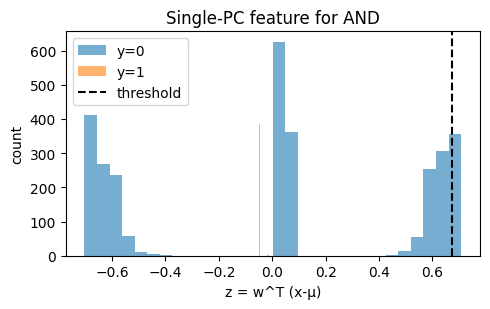

In [28]:
def thresh_from_data(z, y):
    """Find the best classification threshold by scanning percentiles of z.
    
    Args:
        z: scalar feature values from PCA projection
        y: true labels (0 or 1)
        
    Returns:
        best_t: threshold giving highest accuracy
        best_acc: accuracy achieved at best threshold
    """
    best_acc = -1
    best_t = None

    percentiles = np.linspace(5, 95, 20)  
    for p in percentiles:
        t = np.percentile(z, p)
        pred = (z > t).astype(int)
        acc = np.mean(pred == y)
        if acc > best_acc:
            best_acc = acc
            best_t = t

    return best_t, best_acc

    
z = Xc @ w_oja  # scalar feature
# Find best threshold and corresponding accuracy
t_star, acc_star = thresh_from_data(z, y)

# Make predictions using best threshold
pred = (z > t_star).astype(int)

# Build 2x2 confusion matrix
# Rows = true labels, Cols = predicted labels
cm = np.zeros((2,2), int)
for yi, pi in zip(y, pred):
    cm[yi, pi] += 1  # Count (true,pred) occurrences

print("Chosen threshold:", round(float(t_star),4), "  accuracy:", round(float(acc_star),4))
print("Confusion matrix (rows=true, cols=pred):\n", cm)

plt.figure(figsize=(5,3.2))
plt.hist(z[y==0], bins=30, alpha=0.6, label='y=0')
plt.hist(z[y==1], bins=30, alpha=0.6, label='y=1')
plt.axvline(t_star, color='k', linestyle='--', label='threshold')
plt.legend(); plt.xlabel('z = w^T (x-μ)'); plt.ylabel('count'); plt.title('Single-PC feature for AND');
plt.tight_layout(); plt.show()


## Q 7d. — Two PCs with **Sanger/GHA**

Oja’s rule only gives us **one** PC. To learn **multiple** PCs in one pass, we
use **Sanger’s rule** (also called the **Generalized Hebbian Algorithm, GHA**).

- We now have a weight matrix
  \($\mathbf{W} = [\mathbf{w}_1,\dots,\mathbf{w}_k] \in \mathbb{R}^{d \times k}$\).
- For each input \($\mathbf{x}$\), neuron outputs are
  \($\mathbf{y} = \mathbf{W}^\top \mathbf{x}$\), so \($y_i = \mathbf{w}_i^\top \mathbf{x}$\).
- The update for column \(i\) is:
  \[
  $\Delta \mathbf{w}_i = \eta\, y_i \left(
      \mathbf{x} - \sum_{j=1}^{i} y_j\,\mathbf{w}_j
  \right)$.
  \]

Key ideas:

- Each neuron does a Hebbian-plus-normalization update **after removing** the
  contribution of all earlier PCs \($\mathbf{w}_1,\dots,\mathbf{w}_{i-1}$\).
- The learned \($\mathbf{w}_i$\) become approximately **orthonormal** and
  converge to the eigenvectors of the covariance matrix in order:
  \($\mathbf{w}_1$ \to\) first PC, \($\mathbf{w}_2$ \to\) second PC, etc.

For the AND rate dataset in 2-D:

- With \(k=2\), Sanger’s rule should recover both principal directions.
- You can visualize these vectors on top of the scatter plot of \($\mathbf{x}$\)
  to see how they align with the four AND clusters.


W2 (rows):
 [[-0.69549538 -0.71853057]
 [-0.7195321   0.69445919]]
cos(w1,v1)=1.000,  cos(w2,v2)=1.000,  w1·w2=0.001


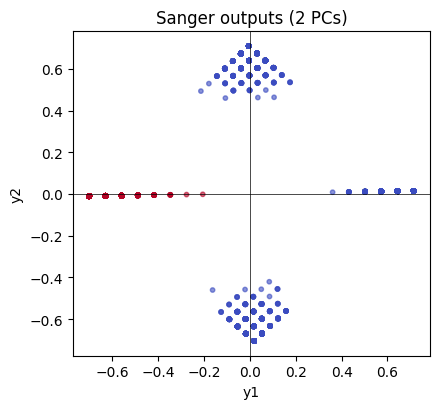

In [29]:
def sanger_fit(Xc, K=2, lr=5e-3, epochs=20, rng=rng):
    """
    Implements Sanger's rule (GHA) for finding K principal components.
    
    Args:
        Xc: Mean-centered data matrix of shape (N, D)
        K: Number of principal components to learn (default=2)
        lr: Learning rate for weight updates (default=5e-3)
        epochs: Number of passes through the dataset (default=20)
        rng: Random number generator for initialization/shuffling
    
    Returns:
        W: Weight matrix of shape (K,D) where rows approximate principal components
    """
    # Initialize random weights for K neurons, each taking D inputs
    N, D = Xc.shape  # Input dimension
    W = rng.normal(size=(K,D)) 
    W /= np.linalg.norm(W, axis=1, keepdims=True)
    
    # Normalize each weight vector to unit length for stability
    

    # Training loop over epochs
    for ep in range(epochs):
        # Process samples in random order each epoch
        perm = rng.permutation(N)
        for i in perm:
            x = Xc[i]
            y = W @ x
            # Compute neuron outputs y = Wx
            for n in range(K):                     
            # Update each neuron's weights in order (k=1,2,...,K)
                proj = np.sum(y[:n+1][:,None] * W[:n+1,:], axis=0)
                W[n] += lr * y[n] * (x - proj)
                # Compute projection onto current and previous neurons
                # Sanger's update: Hebbian term minus projections
                
                
        # Re-normalize weights after each epoch
        W /= np.linalg.norm(W, axis=1, keepdims=True)
        
    
    return W

W2 = sanger_fit(Xc, K=2, lr=5e-3, epochs=30)
print("W2 (rows):\n", W2)

C = (Xc.T @ Xc) / Xc.shape[0]
eigvals, eigvecs = np.linalg.eigh(C)
V = eigvecs[:, ::-1]
cos1 = abs(float(W2[0] @ V[:,0])); cos2 = abs(float(W2[1] @ V[:,1]))
orth = float(W2[0] @ W2[1])
print(f"cos(w1,v1)={cos1:.3f},  cos(w2,v2)={cos2:.3f},  w1·w2={orth:.3f}")

Y2 = Xc @ W2.T
plt.figure(figsize=(4.5,4.2))
plt.scatter(Y2[:,0], Y2[:,1], c=y, cmap='coolwarm', s=10, alpha=0.6)
plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)
plt.xlabel('y1'); plt.ylabel('y2'); plt.title('Sanger outputs (2 PCs)'); plt.tight_layout(); plt.show()


## Q 7e — Reconstruction error vs #PCs and eigenvalues

PCA is often described in terms of **reconstruction**:

- Let the covariance matrix of the data be \($\mathbf{C}$\) with eigenvalues
  \($\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_d$\) and eigenvectors
  (PCs) \($\mathbf{w}_1,\dots,\mathbf{w}_d$\).
- The **total variance** of the data is
  \($\sum_{i=1}^{d} \lambda_i$\).
- If we keep only the first \(k\) PCs, the variance captured is
  \($\sum_{i=1}^{k} \lambda_i$\).
- The expected **reconstruction mean-squared error** when projecting onto the
  first \(k\) PCs is:
  \[
  $E_{\text{recon}}(k) = \sum_{i=k+1}^{d} \lambda_i$,
  \]
  i.e. the sum of the **discarded** eigenvalues.

For this 2-D AND dataset:

- With 1 PC, the reconstruction error is just the second eigenvalue \($\lambda_2$\).
- With 2 PCs, the reconstruction error is essentially 0 (you’re using the full
  2-D space again).
- Plotting reconstruction error vs number of PCs, alongside the eigenvalues
  themselves, makes the link clear:
  - **Large eigenvalues** correspond to important directions in the data.
  - **Discarded eigenvalues** directly measure how much information you lose
    when using only a subset of PCs.


In [30]:
def mse(a,b): return float(np.mean((a-b)**2))
C = (Xc.T @ Xc) / Xc.shape[0]
eigvals, eigvecs = np.linalg.eigh(C)
lam = eigvals[::-1]

# K=1 using Oja (unit norm)
w1 = (W2[0] / (np.linalg.norm(W2[0])+1e-12))
Xh1 = np.outer(Xc @ w1, w1)
mse1 = mse(Xc, Xh1)

# K=2 using Sanger (orthonormalize rows with QR)
Q,_ = np.linalg.qr(W2.T)
W_orth = Q.T
Xh2 = (Xc @ W_orth.T) @ W_orth
mse2 = mse(Xc, Xh2)
total_var = float(np.trace(C))
print(f"MSE K=1: {mse1:.5f}  (drop ≈ λ2={lam[1]:.5f})")
print(f"MSE K=2: {mse2:.5f}  (drop ≈ 0; keeps λ1+λ2={lam.sum():.5f}≈total var {total_var:.5f})")

MSE K=1: 0.10048  (drop ≈ λ2=0.20095)
MSE K=2: 0.00000  (drop ≈ 0; keeps λ1+λ2=0.40995≈total var 0.40995)


---
### What to report (short write‑ups)
- Eigenvalues and a sentence on why $v_1\approx [1,1]/\sqrt{2}$ in balanced AND.
- Oja curves: `cos(w,v1)` rising to ~1 and `E[y^2]` → $\lambda_1$.
- Histograms of the scalar feature `z` with chosen threshold + confusion matrix.
- Sanger alignment (cosines), near‑orthogonality, and 2‑D scatter.
- MSE vs K and relation to eigenvalues.

## Problem 7e Answer
<font color='red'>
The eigenvalues are 0.20899313 0.20095329, and the top eigenvector is approximately [1,1] sqrt2 because the greatest spread direction is on the scalar where both coordinates increase together. 

The Oja curve steadily rises towards 1, which shows that the learned weight vector eventually curves to the first principal component. Ey^2 approaches the largest eigenvalue. 

The scalar feature z with the chosen threshold shows two scatter clusters on opposite sides of the y axis and on the same x axis, which is reflected in the histogram and confusion matrix. 

Using Sanger's rule, we see that the scatter plots reside on two opposite sides of the y axis, and they align strongly with true eigenvectors. 

AS Pcs K increases, the mean squared reconstruction error decreases
</font>

# Problem 8
## 8a. Implement Sejnowski’s Learning Rule

In 1977, Neuroscientist Dr. Terry Sejnowski proposed a form of synaptic modification similar to Hebb’s rule, but with a nonlinear dependence on the postsynaptic firing rate y: $Δw_i=ηy(y−θ)x_i$ where $x_i$ is the presynaptic firing rate, $y$ is the postsynaptic firing rate, $θ$ is the postsynaptic activity threshold, and $η$ is the learning rate. When $y>θ$, weights potentiate (LTP); when  $y<θ$, weights depress (LTD). This introduces a self-stabilizing balance around θ.

In [51]:
def sejnowski_rule(network, train_data, lr=0.01, theta=0.4, epochs=10):
    """
    Function to train a network using Sejnowski's learning rule
        Args:
            network (SNN): SNN network object
            train_data (list): training data 
            lr (float): learning rate
            theta: postsynaptic activity threshold
            epochs (int): number of epochs to train with. Each epoch is defined as one pass over all training samples.
        
        Write the operations required to compute the weight increment according to Sejnowski's learning rule. Then increment the network weights. 
    """
    #iterate over the epochs
    for ee in range(epochs):
        #iterate over all samples in train_data
        for x_spikes, _y_spikes in train_data:
            out_spikes = network(x_spikes)          
            x_mean = x_spikes.mean(axis=1, keepdims=True).T   
            y_mean = network(x_spikes).mean()                 
            delta_w = lr * y_mean * (y_mean - theta) * x_mean  
            network.input_2_output_connection.weights += delta_w

## 8b. Implement the BCM (Bienenstock–Cooper–Munro) Rule 

The BCM rule (Bienenstock et al., 1982) adds a sliding modification threshold $θ_M$ that depends on the recent average postsynaptic activity: $Δw_i = ηy(y−θ_M)x_i$, and $\frac{dθ_M}{dt} = α(y^2−θ_M)$. When $y>θ_M$, weights potentiate (LTP); $y<θ_M$, weights depress (LTD). $θ_M$ evolves over time to balance potentiation/depression by providing a metaplastic mechanism that keeps the neuron’s output firing rate within a stable range.

In [54]:
def bcm_rule(network, train_data, lr=0.01, alpha=0.05, theta_init=0.3, epochs=10):
    """
    Function to train a network using the BCM learning rule
        Args:
            network (SNN): SNN network object
            train_data (list): training data 
            lr (float): learning rate constant weight update
            alpha: learning rate constant for theta update
            theta_init: initial value for a sliding (adaptive) postsynaptic modification threshold
            epochs (int): number of epochs to train with. Each epoch is defined as one pass over all training samples.
        
        Write the operations required to compute the weight increment according to the BCM learning rule. Then increment the network weights. 
    """
    theta_M = float(theta_init)
    #iterate over the epochs
    for ee in range(epochs):
        #iterate over all samples in train_data
        for x_spikes, _y_spikes in train_data:
            # compute values for weight increment
            # compute weight increment
            out_spikes = network(x_spikes)
            # increment the weight
            x_mean = x_spikes.mean(axis=1, keepdims=True).T   # shape (1,2)
            y_mean = network(x_spikes).mean()                 # scalar
            delta_w = lr * y_mean * (y_mean - theta_M) * x_mean
            network.input_2_output_connection.weights += delta_w
            theta_M += alpha * (y_mean**2 - theta_M)

    return theta_M

## 8c. Compare Learning Rules Experimentally on Changing Inputs

You’ll implement and compare five learning rules in a tiny SNN (2 inputs → 1 output): Hebbian (plain), Oja, Sejnowski, BCM, and STDP.

You will run two experiments:

**Task A** — Non-stationary Feature Tracking: Generate spike streams where the input covariance changes halfway through training:
* Phase 1 (epochs 1…E/2): variance aligned with vector v₁ = [1, 0.2]ᵀ
* Phase 2 (epochs E/2+1…E): variance aligned with v₂ = [0.2, 1]ᵀ

Train your single-output neuron with each rule (starting from the **same** random weights). At each epoch, present new random spike trains (rate-coded). After each epoch, compute the angle between the synaptic weight vector w and the current empirical first principal component (PC₁) of the input stream.

What to look for:
* Oja: angles drop toward ~0° in Phase 1, then re-align toward v₂ in Phase 2.
* Hebb: weight norm explodes; angle is unreliable.
* Sejnowski (fixed θ): can stabilize near θ but may fail to track the principal component switch unless θ is tuned.
* BCM: sliding θ homeostatically keeps firing near a target; tracks the principal component switch but can lag the switch.
* STDP: not a rate/principal component learner; angles will be noisy/uninformative.

**Task B** — Temporal Causality (pre→post timing)
* Make x₁ spikes tend to precede x₂ by Δt in Phase 1; reverse the order in Phase 2.

Train the same neuron with STDP and compare to rate-rules just as you do for Task A. Report the sign and magnitude of w₁ vs w₂ at the end of each phase.

What to look for:
* STDP: w₁ > w₂ after Phase 1 (x₁ leads), then flips to w₂ > w₁ after Phase 2.
* Hebb/Oja/Sejnowski/BCM: largely fail to flip based on timing alone.

**Note**: Test your implementation below and explain the observed result (make sure to compare across learning rules for both tasks). **Interpret** the output of the results, make sure to **explain** what the magnitude of the weight vector and the angle between the weight vector and first principal component tell us and **what they mean**.

In [57]:
# =========================
# Helpers: angles, PCs, generators
# DO NOT CHANGE ANYTHING HERE
# =========================
def _angle_deg(u, v, eps=1e-9):
    u = u.ravel().astype(float); v = v.ravel().astype(float)
    nu = np.linalg.norm(u) + eps; nv = np.linalg.norm(v) + eps
    cos = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return float(np.degrees(np.arccos(cos)))

def _pc1_from_spikes(X):
    Xc = X - X.mean(axis=1, keepdims=True)
    C = Xc @ Xc.T / max(1, X.shape[1] - 1)
    vals, vecs = np.linalg.eigh(C)
    v = vecs[:, np.argmax(vals)]
    if v[0] < 0: v = -v
    return v

def gen_phase_spikes_cov(T, v_dir, lo=0.02, hi=0.25, mix=0.15, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    v = np.asarray(v_dir, dtype=float)
    v = v / (np.linalg.norm(v) + 1e-9)
    u = np.array([-v[1], v[0]])
    z_major = rng.random(T) < hi
    z_minor = rng.random(T) < lo
    z_iso   = rng.random((2, T)) < mix
    x = (np.outer(v, z_major.astype(float)) +
         np.outer(u, z_minor.astype(float))) > 0.5
    X = x.astype(int) | z_iso.astype(int)
    return X

def gen_phase_spikes_temporal(T, lead=0, lag=2, base=0.05, burst=0.35, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    x1 = (rng.random(T) < base).astype(int)
    x2 = (rng.random(T) < base).astype(int)
    if lead == 1:
        for t in range(T - lag):
            if x1[t] == 1 and rng.random() < burst:
                x2[t + lag] = 1
    elif lead == 2:
        for t in range(T - lag):
            if x2[t] == 1 and rng.random() < burst:
                x1[t + lag] = 1
    return np.stack([x1, x2])

# =========================
# One-step adapters that use your learning rule functions defined above
# DO NOT CHANGE ANYTHING HERE
# =========================
def sejnowski_step(network, X, lr=0.01, theta=0.4, repeats=1):
    train_data = [(X, None)] * repeats
    sejnowski_rule(network, train_data, lr=lr, theta=theta, epochs=1)

def bcm_step(network, X, theta_M, lr=0.01, alpha=0.05, repeats=1):
    train_data = [(X, None)] * repeats
    theta_M = bcm_rule(network, train_data, lr=lr, alpha=alpha, theta_init=theta_M, epochs=1)
    return theta_M

def hebbian_step(network, X, y_teacher, lr=1e-5, repeats=1):
    train_data = [(X, y_teacher)] * repeats
    hebbian(network, train_data, lr=lr, epochs=1)

def oja_step(network, X, y_teacher, lr=1e-5, repeats=1):
    train_data = [(X, y_teacher)] * repeats
    oja(network, train_data, lr=lr, epochs=1)

# =========================
# Task A: Non-stationary feature tracking
# =========================
def taskA_compare_rules(epochs=80, T=90, seed=123):
    rng = np.random.default_rng(seed)
    W0 = rng.uniform(-1.2, 1.2, size=(1, 2)) #Initialize weights

    nets = { # Initialize Networks
        'Hebb':       SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T),
        'Oja':        SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T),
        'Sejnowski':  SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T),
        'BCM':        SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T),
        'STDP':       SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T),
    }

    v1 = np.array([1.0, 0.2]); v2 = np.array([0.2, 1.0])
    phase_switch = epochs // 2

    bcm_theta = 0.3

    print("\n=== Task A: Non-stationary feature tracking ===")
    for e in range(epochs):
        v = v1 if e < phase_switch else v2
        X = gen_phase_spikes_cov(T, v, lo=0.08, hi=0.50, mix=0.25, rng=rng)
        pc1 = _pc1_from_spikes(X)
        y_teacher = (X[0] | X[1]).astype(int)

        for _ in range(3):
            hebbian_step(nets['Hebb'], X, y_teacher, lr=1e-5, repeats=1)
            oja_step(nets['Oja'], X, y_teacher, lr=1e-5, repeats=1)
            sejnowski_step(nets['Sejnowski'], X, lr=0.01, theta=0.4, repeats=1)
            bcm_theta = bcm_step(nets['BCM'], X, theta_M=bcm_theta, lr=0.01, alpha=0.05, repeats=1)
            stdp_tr = STDP(nets['STDP'], A_plus=0.01, A_minus=0.01, tau_plus=5, tau_minus=5, lr=0.01, snn_timesteps=T, epochs=1, w_min=-2.0, w_max=2.0)
            stdp_tr.train([(X, y_teacher)])

        if e in (phase_switch-1, phase_switch, epochs-1):
            for name, net in nets.items():
                w = net.input_2_output_connection.weights.ravel()
                ang = _angle_deg(w, pc1)
                print(f"Epoch {e+1:03d} [{name}] angle(w, PC1) = {ang:6.2f} deg, |w|={np.linalg.norm(w):.3f}")

    print("\nFinal weight vectors:")
    for name, net in nets.items():
        print(f"{name:10s}: w = {net.input_2_output_connection.weights.ravel()}")

# =========================
# Utility; DO NOT CHANGE
# =========================
def _delayed(arr, lag):
    y = np.zeros_like(arr)
    T = len(arr)
    if lag > 0:
        y[lag:] = arr[:-lag]
    elif lag < 0:
        k = -lag 
        if k < T:
            y[:T-k] = arr[k:]
    else:
        y[:] = arr
    return y

# =========================
# Task B: Temporal causality
# =========================
def taskB_temporal_causality(epochs=60, T1=120, T2=420, seed=321,
                             base_phase1=0.10, burst_phase1=0.60,
                             base_phase2=0.08, burst_phase2=0.80,
                             k_stdp_phase1=1, k_stdp_phase2=3):
    rng = np.random.default_rng(seed)
    W0 = rng.uniform(-0.35, 0.35, size=(1, 2)) #Initialize Weights

    def make_net(T=T1):
        return SNN(W0.copy(), 2, 1, vdecay=0.5, vth=0.60, snn_timestep=T)

    nets = {
        'Hebb':       SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T1),
        'Oja':        SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T1),
        'Sejnowski':  SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T1),
        'BCM':        SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T1),
        'STDP':       SNN(W0.copy(), input_dimension=2, output_dimension=1, vdecay=0.5, vth=0.5, snn_timestep=T1),
    }

    bcm_theta_map = {name:0.3 for name in nets.keys()}

    phase_switch = epochs // 2
    lag_gen = 2
    teacher_lag = -lag_gen

    print("\n=== Task B: Temporal causality (who leads) ===")
    for e in range(epochs):
        in_phase2 = (e >= phase_switch)
        T = T2 if in_phase2 else T1
        base = base_phase2 if in_phase2 else base_phase1
        burst = burst_phase2 if in_phase2 else burst_phase1
        k_stdp = k_stdp_phase2 if in_phase2 else k_stdp_phase1

        for net in nets.values():
            net.snn_timestep = T

        lead = 1 if e < phase_switch else 2
        X = gen_phase_spikes_temporal(T, lead=lead, lag=lag_gen, base=base, burst=burst, rng=rng)
        y_out = _delayed(X[0], teacher_lag) if lead == 1 else _delayed(X[1], teacher_lag)

        for _ in range(3):
            hebbian_step(nets['Hebb'], X, y_out, lr=1e-5, repeats=1)
            oja_step(nets['Oja'], X, y_out, lr=1e-5, repeats=1)
            sejnowski_step(nets['Sejnowski'], X, lr=0.01, theta=0.4, repeats=1)
            bcm_theta_map['BCM'] = bcm_step(nets['BCM'], X, theta_M=bcm_theta_map['BCM'], lr=0.01, alpha=0.05, repeats=1)
            stdp_tr = STDP(nets['STDP'], A_plus=0.01, A_minus=0.01, tau_plus=5, tau_minus=5, lr=0.01, snn_timesteps=T, epochs=k_stdp, w_min=-2.0, w_max=2.0)
            stdp_tr.train([(X, y_out)])

        if e in (phase_switch-1, phase_switch, epochs-1):
            print(f"\nEpoch {e+1:03d} (lead = x{lead})")
            for name, net in nets.items():
                w = net.input_2_output_connection.weights.ravel()
                pref = "x1" if w[0] > w[1] else "x2"
                print(f"{name:10s}: w = {w},  -> prefers {pref}")

    print("\nFinal preference after Phase 1 then Phase 2:")
    for name, net in nets.items():
        w = net.input_2_output_connection.weights.ravel()
        pref = "x1" if w[0] > w[1] else "x2"
        print(f"{name:10s}: prefers {pref}")

# ===== Run Task A (feature tracking) =====
taskA_compare_rules(epochs=80, T=60, seed=123)

# ===== Run Task B (temporal causality) =====
taskB_temporal_causality(epochs=60, seed=321)



=== Task A: Non-stationary feature tracking ===
Epoch 040 [Hebb] angle(w, PC1) =  44.88 deg, |w|=1.157
Epoch 040 [Oja] angle(w, PC1) =  44.88 deg, |w|=1.156
Epoch 040 [Sejnowski] angle(w, PC1) =  46.11 deg, |w|=1.158
Epoch 040 [BCM] angle(w, PC1) =  44.65 deg, |w|=1.157
Epoch 040 [STDP] angle(w, PC1) =  35.04 deg, |w|=2.361
Epoch 041 [Hebb] angle(w, PC1) = 144.36 deg, |w|=1.157
Epoch 041 [Oja] angle(w, PC1) = 144.36 deg, |w|=1.156
Epoch 041 [Sejnowski] angle(w, PC1) = 145.59 deg, |w|=1.158
Epoch 041 [BCM] angle(w, PC1) = 144.14 deg, |w|=1.157
Epoch 041 [STDP] angle(w, PC1) = 134.11 deg, |w|=2.372
Epoch 080 [Hebb] angle(w, PC1) =   9.02 deg, |w|=1.156
Epoch 080 [Oja] angle(w, PC1) =   9.02 deg, |w|=1.155
Epoch 080 [Sejnowski] angle(w, PC1) =  10.31 deg, |w|=1.159
Epoch 080 [BCM] angle(w, PC1) =   8.81 deg, |w|=1.157
Epoch 080 [STDP] angle(w, PC1) =  13.70 deg, |w|=2.828

Final weight vectors:
Hebb      : w = [ 0.43842279 -1.07001195]
Oja       : w = [ 0.43785945 -1.06863549]
Sejnowski 

## Answer 8c.
<font color='red'>
The weight vector shows how strongly each input feature influences the neuron, and its magnitude shows  the overall strength. The angle between the weight and the first component shows how well the weights align with the main direction of input activity, and smaller angles mean better alignment. At first, the angles are larger, meaning the weights are not yet aligned with the main feature, but at the end, angles are small, so the networks track the main feature.
</font>

## Problem 8d — Conceptual Comparison

In 3–5 sentences each, explain:
* Hebbian instability: Why does plain Hebb lead to runaway excitation?
* Normalization (Oja): How does Oja’s rule constrain this?
Homeostatic thresholds (Sejnowski & BCM):
* How does Sejnowski’s fixed threshold compare to BCM’s adaptive one?
Relation to STDP:
* How do these rate-based rules approximate pair-based or triplet-based STDP in time-averaged form?

## Answer 8d.

<font color='red'>

Hebbian learning strengthens whenever neurons fire together, and has no clause for decreasing the weights. We get saturation from the weights increasing exponentially over epochs and timesteps. 

Oja’s rule keeps the weights from growing too big by scaling them down over time. This stops the runaway growth while still letting the neuron learn patterns.

Sejnowski uses a fixed firing threshold to limit weight growth, while BCM changes the threshold over time depending on how active the neuron is. This threshold helps BCM adjust to different input levels.

These rules look at average firing rates over time, which is like STDP but smoothed out. Instead of exact spike timing, they adjust weights based on how often pre- and post-synaptic neurons are active together.
</font>

# Question 9 – Reward‑Modulated STDP (R‑STDP) on a 2‑Arm Bandit

Previously you saw **unsupervised** rules (Hebb / Oja) that move weights toward
directions of *high variance* or *correlation* in the input.  
In this question you add a **task** and a **reward**, and let the synapse decide whether a correlation was “good” or “bad”.

The toy task is a **2-armed bandit** — the minimal RL problem — so that the
math and code stay small while the ideas are exactly the same as in large-scale
actor-critic / policy-gradient algorithms.

The central challenge is the exploration-exploitation trade-off.
 
- An agent must decide whether to exploit its current knowledge by choosing the arm with the highest estimated reward or to explore other arms that might have higher potential rewards but are currently less understood.

- The problem is framed as a set of K arms (actions), where each arm's reward is drawn from a fixed but initially unknown probability distribution.

- The agent's goal is to maximize its cumulative reward over a series of turns by learning which arm is the best and consistently choosing it.

https://en.wikipedia.org/wiki/Multi-armed_bandit

**Goal.** Implement a tiny spiking network that learns to solve a simple **2‑armed bandit**
task using a **reward‑modulated STDP** rule.


### Learning objectives
- Understand the difference between **Hebbian/Oja** learning and **reward‑modulated STDP**.
- Implement a minimal **spiking policy** with 1 input neuron and 2 output neurons.
- Train that policy with R‑STDP and interpret the learning curves.


## 9a. Environment: 2‑arm bandit

- On each trial \(t\) you choose an action  
  \[
  $a_t \in \{0,1\}$.
  \]
- **Arm 0** is the “better” arm:  
  \[
  $R_t =
    \begin{cases}
      +1 & \text{with probability } p_{\text{good}} \\
      -1 & \text{with probability } 1-p_{\text{good}}
    \end{cases}$
  \]
- **Arm 1** is worse: its success probability is \($1-p_{\text{good}}$\).

Key ideas:

- There is **no state**, only a repeated choice → bandit, not full RL.
- There is **stochastic reward**: even the good arm sometimes loses.
- The optimal policy is simply “pick arm 0 almost all the time”, but the agent
  does **not** know which arm is good at the start and must **explore**.

You will plot:

- A moving average of reward (fraction of wins).
- An exponential moving average of **accuracy** (how often the agent picks the
  actually-better arm).

These curves tell you whether learning is working.


In [58]:
rng_global = np.random.default_rng(0)

def bandit_step(action, p_good=0.6, rng=None):
    """One step of a 2‑arm bandit. Returns reward r ∈ {+1, −1}.
    
    Args:
        action (int): Which arm to pull (0 or 1)
        p_good (float): Probability of reward=+1 for arm 0 (default 0.6)
        rng: Random number generator (optional)
        
    Returns:
        int: Reward (+1 or -1)
    """
    # Use global RNG if none provided
    
    # Get success probability based on which arm was chosen
    # Arm 0 has p_good probability of reward
    # Arm 1 has (1-p_good) probability of reward
    
    # Return +1 with probability p, else -1
    if rng is None:
        rng = rng_global
    
    # Determine success probability for chosen arm
    p = p_good if action == 0 else 1 - p_good
    
    # Return +1 with probability p, else -1
    return 1 if rng.random() < p else -1 

# quick check
for a in [0, 1]:
    rs = [bandit_step(a, p_good=0.7) for _ in range(1000)]
    print(f"Empirical mean reward for arm {a}: {np.mean(rs):.3f}")


Empirical mean reward for arm 0: 0.356
Empirical mean reward for arm 1: -0.346


## Q 9b. Tiny SNN policy: 1 input → 2 outputs

To keep the focus on plasticity, we use the smallest possible SNN:

- One **always-spiking input neuron** (“context = I’m making a choice now”).
  - You can think of its firing rate as fixed at 1 spike per trial, so “pre”
    is always active.
- Two **output neurons** corresponding to the two actions:
  - Their synaptic weights from the input are \($w_0$\) and \($w_1$\).
  - Higher weight → higher firing propensity → higher action probability.

We turn these two weights into a **stochastic policy** via a softmax:
\[
$\pi(a = i) = \frac{\exp(w_i / \text{temp})}
                  {\exp(w_0 / \text{temp}) + \exp(w_1 / \text{temp})},
\quad i \in \{0,1\}$.
\]

- `temp` (temperature) controls **exploration**:
  - High `temp` → weights are “blurred” → actions more random.
  - Low `temp` → softmax sharper → the currently larger weight is chosen
    almost greedily.

This is conceptually the same as a **policy network** in RL, but with just
1×2 weights and 2 spikes.

In [65]:
class TinyBanditSNN:
    """1‑input, 2‑output policy with R‑STDP‑style weight updates."""
    def __init__(self, lr=1e-2, temp=0.5):
        self.w = np.zeros(2, dtype=float)
        self.lr = float(lr)
        self.temp = float(temp)

    def policy(self):
        """Softmax over weights → action probabilities."""
        logits = self.w / self.temp
        exps = np.exp(logits - logits.max())
        return exps / exps.sum()

    def act(self, rng=None):
        if rng is None:
            rng = rng_global
        p = self.policy()
        return 0 if rng.random() < p[0] else 1

    def rstdp_update(self, action, reward):
        """Reward‑modulated STDP for chosen action.
        
        Args:
            action: The action chosen (0 or 1)
            reward: The reward received (+1 or -1)
            
        Updates:
            Only the weight corresponding to the chosen action is modified.
            The update is proportional to:
            - The reward (positive = strengthen, negative = weaken)
            - A quadratic term (1-w^2) that bounds weights to [-1,1]
            
        The quadratic term implements soft bounds on the weights:
        - As w approaches +1 or -1, (1-w^2) approaches 0
        - This prevents runaway weight growth while allowing exploration
        """
        # Convert action to integer index
        
        # Convert reward to float 
                
        # Update only the weight for the chosen action
        # Multiply learning rate * reward * (1-w^2) term
        
        # Hard clip weights to [-1,1] for stability
        action = int(action)
        reward = float(reward)
        delta = self.lr * reward * (1 - self.w[action]**2)
        self.w[action] += delta
        self.w[action] = np.clip(self.w[action], -1.0, 1.0)

# quick check
net = TinyBanditSNN(lr=1e-2, temp=0.5)
print("Initial weights:", net.w)
print("Initial policy probs:", net.policy())


Initial weights: [0. 0.]
Initial policy probs: [0.5 0.5]


## Q 9c. Training loop with R‑STDP

Recall pure Hebbian / Oja-style updates:

- **Hebb:** \($\Delta w \propto \text{pre} \cdot \text{post}$\).
- **Oja:** \($\Delta w = \eta\, y(\mathbf{x} - y\mathbf{w})$\).

Those rules *always* change the weight whenever pre and post are active.
They do not know if that change helped or hurt the task.

For **R-STDP** we introduce a **global reward signal** \($R_t$\) and gate the
plasticity with it. Conceptually:

1. During the trial, synapses build up an **eligibility trace**
   \($e_t \sim \text{pre} \times \text{post}$\) — “this synapse was involved”.
2. At the end of the trial a scalar **reward** \($R_t$\) arrives.
3. The actual weight change is:
   \[
   $\Delta w \propto (R_t - b) \cdot e_t$,
   \]
   where \(b\) is a **baseline** (running average of reward).

In this bandit SNN:

- Pre = 1 (always on input).
- Post = 1 for the **chosen** output neuron only.
- We update only the chosen synapse \(w_a\):
  \[
  $\Delta w_a = \eta\, (R_t - b)\, e_t - \lambda w_a$.
  \]
  - If \($R_t > b$\) (better-than-expected reward) and \($e_t > 0$\):  
    weight **increases** → action more likely next time.
  - If \($R_t < b$\): weight **decreases** → action less likely.
  - \($-\lambda w_a$\) is a small **weight decay** that prevents divergence.

The baseline \(b\) is updated slowly:
\[
$b \leftarrow (1-\alpha_b)\,b + \alpha_b\,R_t$,
\]
so it tracks the long-term average reward and reduces gradient variance (exactly
the idea of a “variance-reduced” policy gradient).


Final weights: [ 0.99862994 -0.44356692]


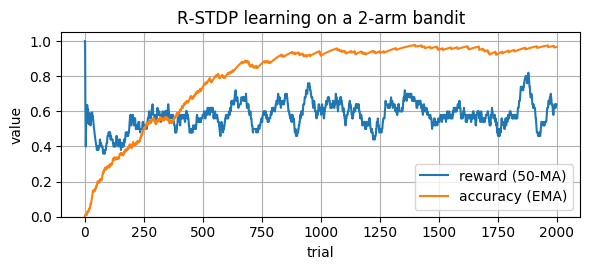

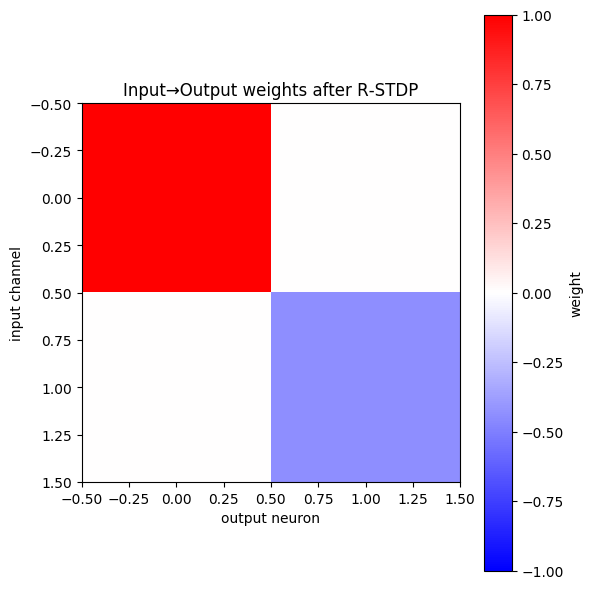

In [66]:
def train_rstdp_bandit(T=2000, p_good=0.6, lr=1e-2, temp=0.5,
                       ma_win=50, ema_alpha=0.01, seed=0):
    rng = np.random.default_rng(seed)
    net = TinyBanditSNN(lr=lr, temp=temp)

    reward_ma = []
    acc_ema   = []
    buf = []
    acc_val = 0.0

    # Training loop over T trials
    for t in range(T):
        # Choose an action using the SNN's policy
        a = net.act(rng=rng)
        
        # Get reward from bandit (+1 or -1)
        r = bandit_step(a, p_good=p_good, rng=rng)
               
        # Update the network weights using R-STDP rule
        
        # Track moving average of rewards:
        # Convert reward to binary (1=win, 0=loss) 
        net.rstdp_update(a, r)
        
        # Keep buffer at fixed window size
        buf.append(1 if r > 0 else 0)
        if len(buf) > ma_win:
            buf.pop(0)
            
        # Compute average over window
        reward_ma.append(sum(buf)/len(buf))

        # Track exponential moving average of accuracy:
        # correct = 1 if chose arm 0 (the better arm)
        correct = 1 if a == 0 else 0
        # Update EMA with new accuracy value
        acc_val = (1 - ema_alpha) * acc_val + ema_alpha * correct
        # Store current EMA value
        acc_ema.append(acc_val)

    return net, np.array(reward_ma), np.array(acc_ema)

net, reward_ma, acc_ema = train_rstdp_bandit(T=2000, p_good=0.6, lr=1e-2, temp=0.5)
print("Final weights:", net.w)

T_steps = len(reward_ma)
plt.figure(figsize=(6, 2.8))
plt.plot(range(T_steps), reward_ma, label='reward (50‑MA)')
plt.plot(range(T_steps), acc_ema,   label='accuracy (EMA)')
plt.ylim(0, 1.05)
plt.xlabel('trial'); plt.ylabel('value')
plt.title('R‑STDP learning on a 2‑arm bandit')
plt.grid(True); plt.legend(); plt.tight_layout();
plt.show()

plt.figure(figsize=(6,6))
W_vis = np.array([[net.w[0], 0.0],
                  [0.0,      net.w[1]]])
plt.imshow(W_vis, vmin=-1, vmax=1, cmap='bwr')
plt.colorbar(label='weight')
plt.xlabel('output neuron'); plt.ylabel('input channel')
plt.title('Input→Output weights after R‑STDP')
plt.tight_layout();
plt.show()


### Q 9d. Questions

1. **Eligibility vs. reward.**
   - In your implementation, what quantity corresponds to the **eligibility
     trace**?
   - What is the **global reward** signal here, and when does it arrive in the
     trial?
   - Explain in 2–3 sentences why splitting plasticity into “eligibility ×
     reward” is biologically plausible (local synapse vs. global neuromodulator).

2. **Compare to Oja’s rule.**
   - Oja’s rule changes weights based only on the current input and neuron
     activity; it has **no notion of task or reward**.
   - R-STDP adds a **scalar, global** term \($(R_t - b)$\) that is *shared* by all
     synapses but multiplied by their own local eligibility.
   - Explain why this makes R-STDP a kind of **three-factor rule**:
     \[
      $\Delta w \propto \underbrace{\text{pre}}_{\text{local}}
                        \times \underbrace{\text{post}}_{\text{local}}
                        \times \underbrace{(R-b)}_{\text{global}}$.
     \]
     How is that closer to the idea of policy-gradient RL (REINFORCE) than Oja’s
     purely unsupervised rule?

3. **Effect of \($p_{\text{good}}$\).**
   - Run with `p_good = 0.8`, `0.6`, and `0.5`.
   - When `p_good = 0.8`?
   - When `p_good = 0.6`?
   - When `p_good = 0.5`?

     What should the optimal accuracy be in that case? How does your reward and
     accuracy curve reflect that?

4. **Exploration via temperature `temp`.**
   - High `temp` ⇒ ?
   - Low `temp` ⇒ ?
   - Describe what happens to:
     - the **speed** at which accuracy improves, and
     - the **stability** of the final policy when you sweep `temp` from high to low.


## Q 9d. Answer
<font color='red'>
In the R-STDP bandit function, the eligibility trace corresponds to the local signal at the synapse that says the neuron was chosen. The global reward is the +1 or -1 you get from pulling an arm at the end of the trial. Splitting plasticity into eligibility × reward makes sense because each synapse only needs to know its own activity, while something like dopamine broadcasts the reward everywhere. Compared to Oja's rule, which only looks at input and output activity, R-STDP multiplies that by r and b, making it a three-factor rule that’s like policy-gradient RL: it adjusts weights to favor actions that led to better-than-expected reward. When p_good = 0.8 for example, the network should learn almost always to pick arm 0, so accuracy rises toward 0.8. When p_good = 0.6, accuracy goes toward 0.6, and when p_good = 0.5, the arms are equal, so the best accuracy is 0.5. This can be seen in the reward and accuracy curves. A high temperature makes actions slower but more stable. Low temperature makes the policy faster but less stable. 
High temperature = -0.5
Low temperature = 1.5
</font>